In [52]:
import sklearn
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset, we reserve 20% of data for testing before doing anything. This will be used as unseen data for testing later. It is split using stratify so that the class distribution is preserved in both set.

In [53]:
df = sklearn.datasets.load_breast_cancer(return_X_y=False, as_frame=True)
data = df.data
target = df.target

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)




In [54]:
print("Features of data: ", X_train.columns.tolist())
print("Numbers of features: ", X_train.columns.value_counts().sum())

Features of data:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Numbers of features:  30


In [55]:
print("Target distribution:\n")
print("Malignant: ", np.sum(y_train==0))
print("Benign: ", np.sum(y_train==1))
print("Total: ", y_train.shape[0], "\n")

print("Distribution percentages:")
print("Malignant: ", np.sum(y_train==0) / y_train.shape[0] * 100)
print("Benign: ", np.sum(y_train==1) / y_train.shape[0] * 100)

Target distribution:

Malignant:  170
Benign:  285
Total:  455 

Distribution percentages:
Malignant:  37.362637362637365
Benign:  62.637362637362635


#### Distibution
We see that the distribution is about 63% to 37%, meaning that this is not a very imbalanced dataset, but still it is not 50/50, meaning that a model always guessign Benign would get 63% accuracy. Thus we should think to not use accuracy and ROC only to measure the model, but look at other metrics like precision and recall, which is good for inbalanced datasets.

## Analyzing features:

### Without normalization

In [56]:
X_train.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.067213,19.247363,91.557407,648.541099,0.096167,0.103869,0.089193,0.048344,0.180618,0.062820,...,16.177226,25.647297,106.625297,869.026593,0.132329,0.254329,0.276578,0.113904,0.290865,0.083945
std,3.499380,4.405291,24.149231,344.944564,0.013458,0.053522,0.081747,0.038925,0.028074,0.007159,...,4.770020,6.225470,33.195053,552.926912,0.022550,0.159882,0.215937,0.066784,0.064624,0.018408
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.635000,16.000000,74.720000,415.650000,0.086475,0.063750,0.028010,0.020220,0.161750,0.057685,...,13.010000,21.090000,83.715000,513.900000,0.115950,0.145850,0.107900,0.063390,0.249400,0.071835
50%,13.270000,18.820000,85.980000,541.800000,0.095660,0.090970,0.059990,0.032630,0.178100,0.061440,...,14.910000,25.400000,97.590000,683.400000,0.131400,0.211600,0.229800,0.097220,0.281900,0.079930
75%,15.740000,21.710000,103.700000,770.050000,0.104850,0.130100,0.132200,0.073820,0.195300,0.066250,...,18.550000,29.370000,124.950000,1033.500000,0.146200,0.336800,0.385300,0.162500,0.320100,0.092070
max,28.110000,39.280000,188.500000,2499.000000,0.144700,0.345400,0.426800,0.201200,0.304000,0.097440,...,33.130000,49.540000,229.300000,3432.000000,0.218400,1.058000,1.252000,0.291000,0.663800,0.207500


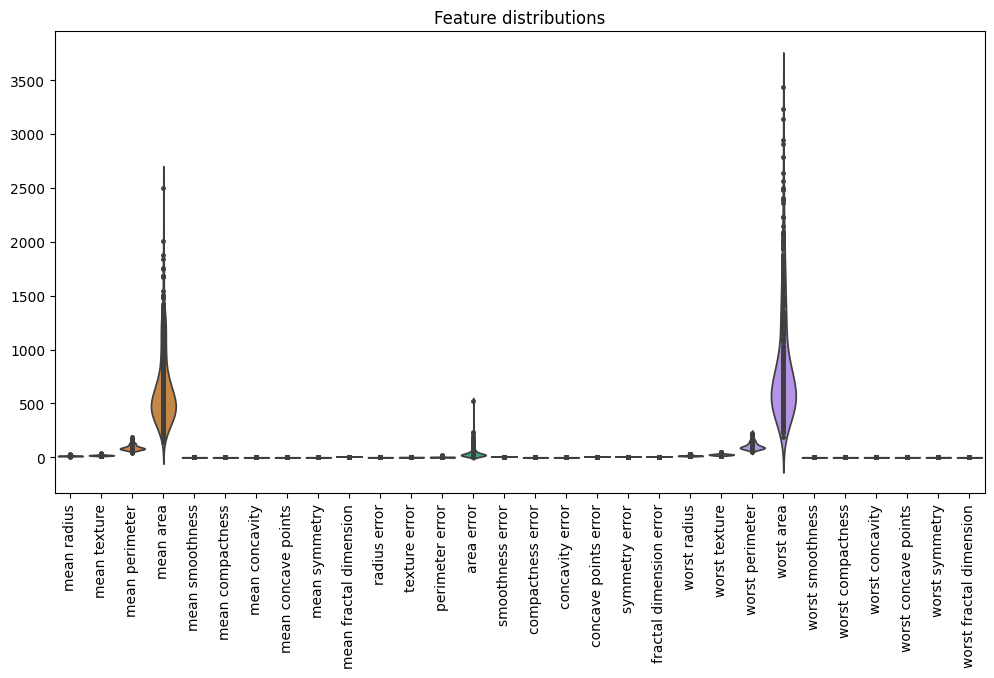

In [57]:

plt.figure(figsize=(12,6))
sns.violinplot(data=X_train, inner="point", density_norm="width")
plt.xticks(rotation=90)
plt.title("Feature distributions")
plt.show()

Here we see that the feature data scales is widely different, especially mean area and worst area which have the majority of its data far above the others in terms of scale. For some models like Decision trees, this will not matter, but for models like regression and SVM like similar data. This is because the models will put more weight on the large-scale features and can make training unstable.

Create a pipeline for preprocessing numerical data. It includes a imputer, which if any NaN values are delivered to the pipeline it will just fill it with the mean of the column. Then it goes through the standarizer, which scales it to zero mean and unit variance. This is useful for models that work better with normal-like data like linear/logistic regression and SVMs.
Min-max scaling could also be an option

In [58]:
num_pipeline = sklearn.pipeline.Pipeline([
    ("impute", sklearn.impute.SimpleImputer(strategy="median")),
    ("standarize", sklearn.preprocessing.StandardScaler())
])

X_train_scaled = num_pipeline.fit_transform(X_train)
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns, 
    index=X_train.index      
)



In [59]:
X_train_scaled.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-2.928061e-16,6.246530e-16,-1.629954e-16,-1.717796e-16,6.246530e-17,-2.088683e-16,-1.561632e-17,6.636938e-17,-2.928061e-16,8.735381e-16,...,4.157846e-16,-3.123265e-17,-2.557173e-16,2.342449e-17,4.714178e-16,-1.952040e-16,1.444510e-16,-2.732857e-17,-1.756836e-16,1.756836e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.027220e+00,-2.167362e+00,-1.980187e+00,-1.465734e+00,-2.503730e+00,-1.580330e+00,-1.092292e+00,-1.243358e+00,-2.660791e+00,-1.798182e+00,...,-1.730874e+00,-2.191368e+00,-1.695348e+00,-1.238101e+00,-2.715107e+00,-1.421602e+00,-1.282241e+00,-1.707442e+00,-2.081459e+00,-1.571972e+00
25%,-6.958063e-01,-7.379620e-01,-6.979907e-01,-6.758983e-01,-7.210063e-01,-7.504076e-01,-7.492716e-01,-7.233200e-01,-6.728116e-01,-7.179958e-01,...,-6.647169e-01,-7.328464e-01,-6.909317e-01,-6.429737e-01,-7.271308e-01,-6.792384e-01,-7.820068e-01,-7.572169e-01,-6.423407e-01,-6.585793e-01
50%,-2.280663e-01,-9.711800e-02,-2.312101e-01,-3.097848e-01,-3.774691e-02,-2.412686e-01,-3.576338e-01,-4.041472e-01,-8.978972e-02,-1.929345e-01,...,-2.659572e-01,-3.976710e-02,-2.724877e-01,-3.360859e-01,-4.123889e-02,-2.675449e-01,-2.168678e-01,-2.501005e-01,-1.388815e-01,-2.183342e-01
75%,4.785500e-01,5.596334e-01,5.033684e-01,3.526440e-01,6.458845e-01,4.906419e-01,5.266743e-01,6.552186e-01,5.235422e-01,4.796473e-01,...,4.979823e-01,5.986377e-01,5.526388e-01,2.977870e-01,6.157967e-01,5.163947e-01,5.040438e-01,7.284559e-01,4.528766e-01,4.418976e-01
max,4.017353e+00,4.552410e+00,4.018733e+00,5.370416e+00,3.610271e+00,4.517740e+00,4.134445e+00,3.931305e+00,4.399657e+00,4.840942e+00,...,3.557938e+00,3.842120e+00,3.699640e+00,4.640386e+00,3.821065e+00,5.032188e+00,4.522140e+00,2.654689e+00,5.777151e+00,6.719538e+00


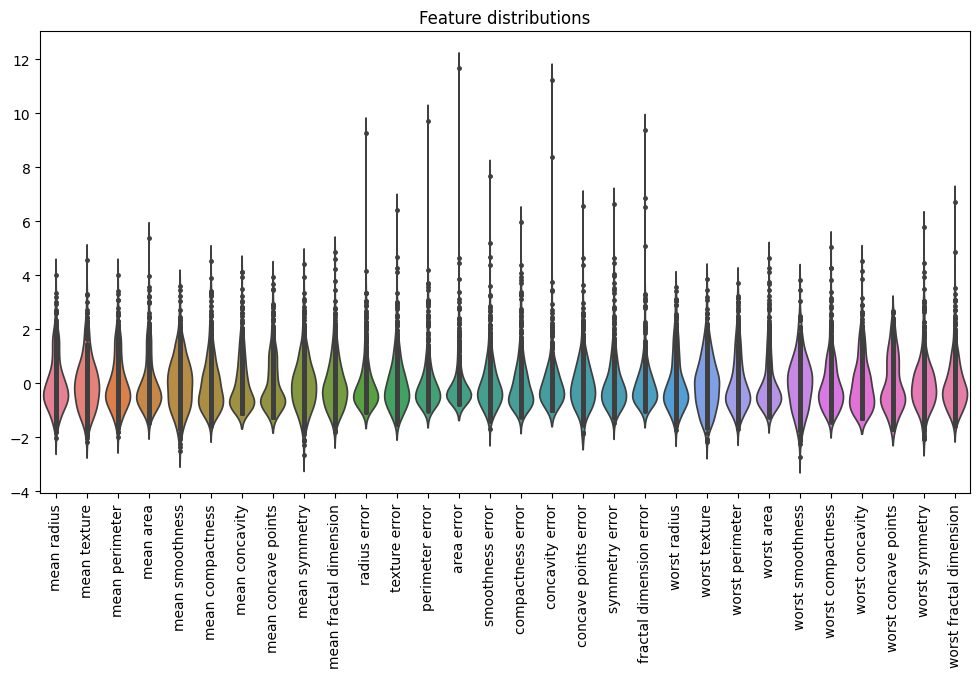

In [60]:


plt.figure(figsize=(12,6))
sns.violinplot(data=X_train_scaled, inner="point", density_norm="width")
plt.xticks(rotation=90)
plt.title("Feature distributions")
plt.show()

We see from the description of the scaled input variables that the mean have now gone down to 0 and that the standard deviation is 1. The plot also shows that most of the data is alligned and similar, which should make training with SVM and regression much more stable. We can then conclude that the features that are standardized are mure suitable for further usage.

## Q1.3 Comment on importance of three way split with respect to hyperparameter search and robustness of any learned model.

Hyperparameters are settings we choose before any training and controls how the learning process is performed. This can be parameters like learning rate, batch rate, regularization parameters or even layers/neurons in deep neural nets. This directly affect how you model turns out and its performance. To get the best hyperparameters we need to test different one to find the ones that yields the best results. To do this we need to have a seperate set of the data to test against and check the models performance. If we were to use the test set, we would break the norm of leaving the test set untouched until the end. This is because we would effectively tweak the model and train if after the testing set. The solution to this is then to create another split from the training data into a validation set. We will then use this validation set to evaluate the model during training and use the result for tweaking of the model to achieve the best result. This will result in a more robust model, because it prevents overfitting and we will in the end have a dataset that the model have not have any interaction with to test its real performance to unseen data.

In [62]:
X_train, X_validation, y_train, y_validation = sklearn.model_selection.train_test_split(X_train_scaled, y_train, test_size=0.2, stratify=y_train, random_state=42)

Now we split the training data into training and validation data. These will be used for training and tweaking of the parameters.

## Exercise-2: Decision Trees

### Q2.1 Train a Decision Tree classifier using default parameters. Evaluate it on validation sets from original splits (report accuracy mean and std).

In [64]:
from sklearn.tree import DecisionTreeClassifier

In [65]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [68]:
y_validation_class_0_percent = np.sum(y_validation==0) / y_validation.shape[0] * 100
y_validation_class_1_percent = np.sum(y_validation==1) / y_validation.shape[0] * 100
print("Validation set class distribution:")
print("Class 0: ", y_validation_class_0_percent)
print("Class 1: ", y_validation_class_1_percent)

Validation set class distribution:
Class 0:  37.362637362637365
Class 1:  62.637362637362635


In [75]:

train_acc = sklearn.metrics.accuracy_score(y_train, tree_model.predict(X_train))
print(f"Training Accuracy: {train_acc*100:.2f}% \n")


y_pred_val = tree_model.predict(X_validation)
accuracy = sklearn.metrics.accuracy_score(y_validation, y_pred_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")



Training Accuracy: 100.00% 

Validation Accuracy: 94.51%


In [70]:
leaf_count = tree_model.get_n_leaves()
print(f"Number of leaves in the tree: {leaf_count}")
depth = tree_model.get_depth()
print(f"Depth of the tree: {depth}")


Number of leaves in the tree: 16
Depth of the tree: 6


This is the result of a completely standard single decision tree, with standard parameters. We see that the model ended with a depth of 6 and 16 total leaves in the tree. These make out the complexity of the model and when is not regularized, can result in the model overfitting to the data. We see that the model achieved a training accuracy of 100% on the training data, but when evaluated on validation it drops to 94%. This is because the tree is overfitting on the training data and drops in performance when seeing new data. 

### Decision tree

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-val Accuracy Mean: {cv_scores.mean():.3f}")
print(f"Cross-val Accuracy Std:  {cv_scores.std():.3f}")

# Fitting the model on the entire training set and evaluating on hold-out validation set
tree_model.fit(X_train, y_train)
val_pred = tree_model.predict(X_validation)
val_acc = accuracy_score(y_validation, val_pred)
print(f"Final Validation Accuracy: {val_acc:.3f}")


Cross-val Accuracy Mean: 0.923
Cross-val Accuracy Std:  0.024
Final Validation Accuracy: 0.945


Here we do cross validation on 5 different splits on the training data just to analyze the variance of the splitting of training data and validation. We see that the variance is pretty low and the final validation was similar to the mean of the cross validation. This means that the evaluation on the validation set is pretty consistent. 

### Random forest result

In [84]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_training_acc = sklearn.metrics.accuracy_score(y_train, rf_model.predict(X_train))
print(f"Random Forest Training Accuracy: {rf_training_acc*100:.2f}% \n")

rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="accuracy")
print(f"Random Forest Cross-val Accuracy Mean: {rf_cv_scores.mean():.3f}")
print(f"Random Forest Cross-val Accuracy Std:  {rf_cv_scores.std():.3f}")
rf_val_pred = rf_model.predict(X_validation)
rf_val_acc = accuracy_score(y_validation, rf_val_pred)
print(f"Random Forest Final Validation Accuracy: {rf_val_acc:.3f}")

Random Forest Training Accuracy: 100.00% 

Random Forest Cross-val Accuracy Mean: 0.953
Random Forest Cross-val Accuracy Std:  0.024
Random Forest Final Validation Accuracy: 0.956


In [83]:
amount_of_trees = rf_model.n_estimators
print(f"Number of trees in the Random Forest: {amount_of_trees}")

average_depth = np.mean([estimator.get_depth() for estimator in rf_model.estimators_])
print(f"Average depth of trees in the Random Forest: {average_depth:.2f}")

Number of trees in the Random Forest: 100
Average depth of trees in the Random Forest: 6.19


A problem with a decision tree is that the variance of the model is high and its performance can therefor be inconsistent. To reduce this variance we create an ensemble of decision trees and aggregate their results. Here we create a random forest of 100 decision trees and see that the accuracy increased from the decision tree. This model also uses bagging, which samples training data with replacement. This is done to reduce the variance, because the different trees. have very different training data. We still have not included any regularizing parameters, so we see that the forest still overfit on the training data and the accuracy is only around 95%.

### Q2.2 From the trained model, comment on feature importance values and identify the top 3 features from your model.

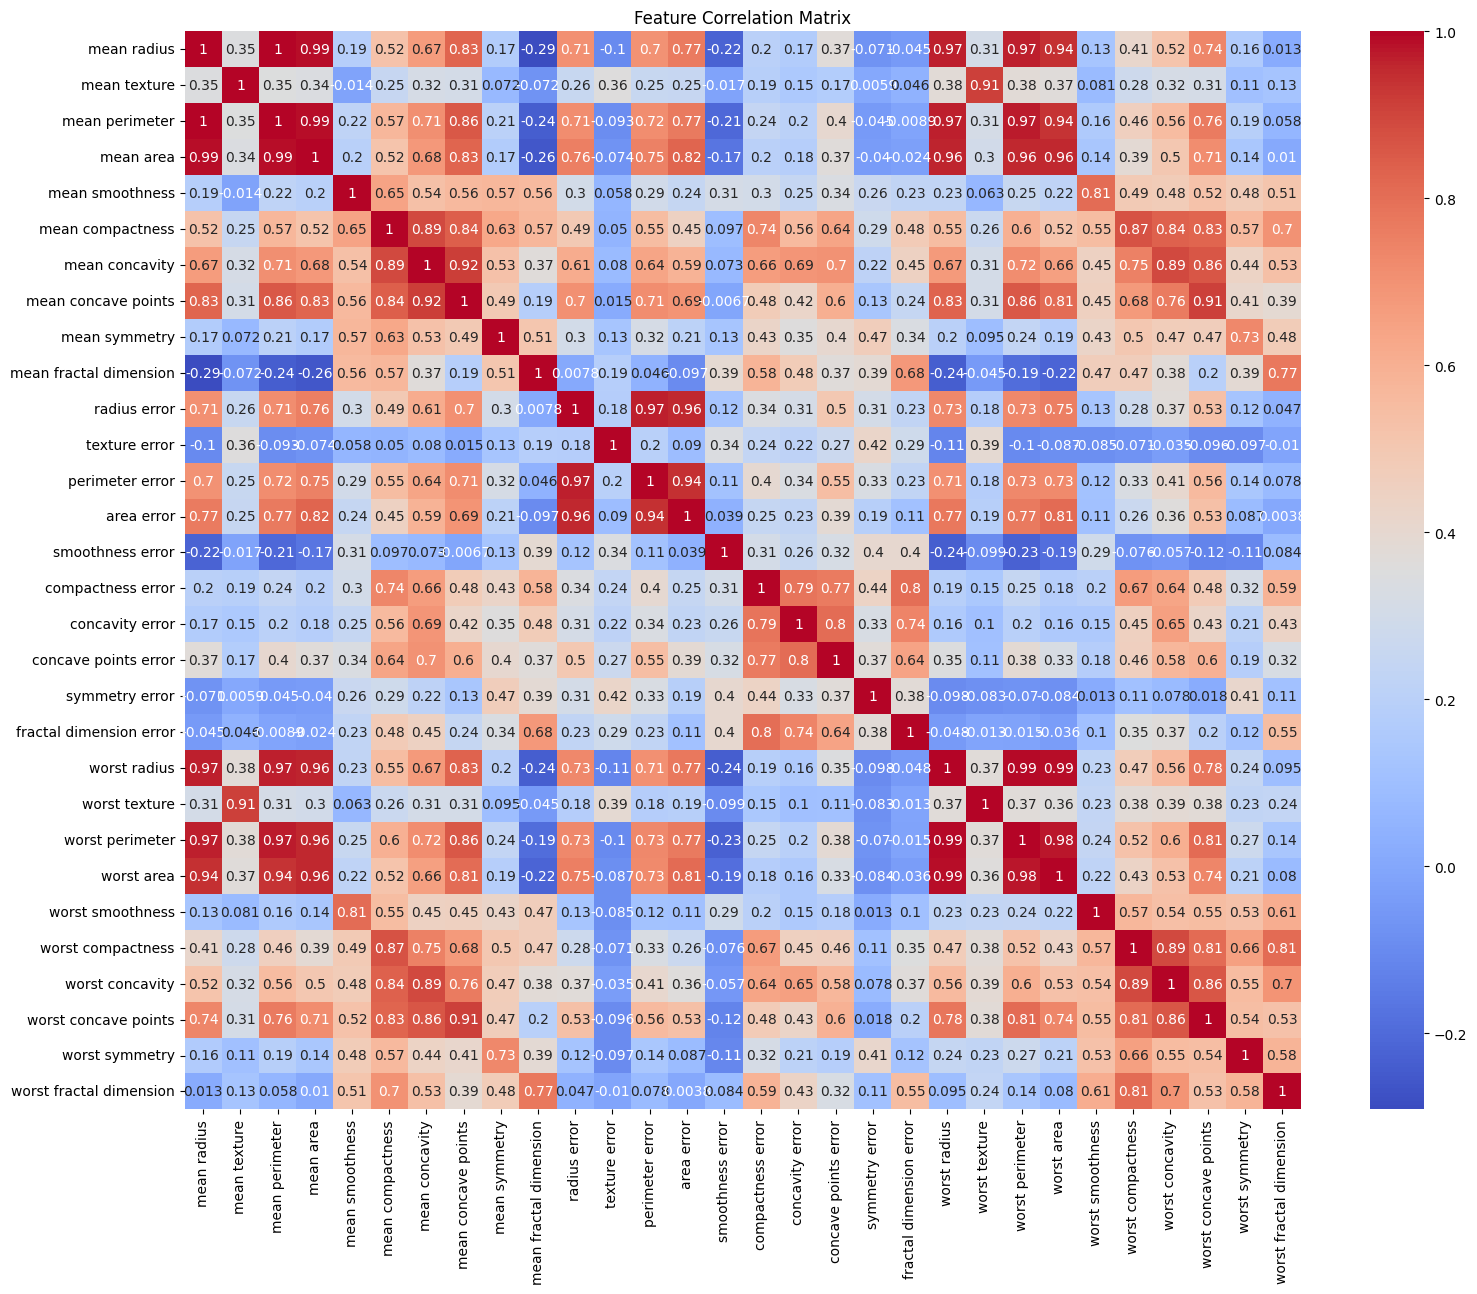

In [ ]:
plt.figure(figsize=(18,14))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [88]:
for feature in correlation_matrix.columns:
    high_corr_features = correlation_matrix.index[correlation_matrix[feature] > 0.75].tolist()
    if high_corr_features:
        print(f"Features highly correlated with {feature}: {high_corr_features}")

Features highly correlated with mean radius: ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'area error', 'worst radius', 'worst perimeter', 'worst area']
Features highly correlated with mean texture: ['mean texture', 'worst texture']
Features highly correlated with mean perimeter: ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'area error', 'worst radius', 'worst perimeter', 'worst area', 'worst concave points']
Features highly correlated with mean area: ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'radius error', 'area error', 'worst radius', 'worst perimeter', 'worst area']
Features highly correlated with mean smoothness: ['mean smoothness', 'worst smoothness']
Features highly correlated with mean compactness: ['mean compactness', 'mean concavity', 'mean concave points', 'worst compactness', 'worst concavity', 'worst concave points']
Features highly correlated with mean concavity: ['mean compactness', 'mean conca

In [91]:
for score, name in sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[:3]:
    print(f"Feature: {name}, Importance Score: {score:.4f}")

#correlation between area and concave points and perimiter
print("\n")
print("Correlation between mean area and mean concave points: ", correlation_matrix.loc['mean area', 'mean concave points'])
print("Correlation between mean area and mean perimeter: ", correlation_matrix.loc['mean area', 'mean perimeter'])


Feature: worst concave points, Importance Score: 0.1562
Feature: worst area, Importance Score: 0.1505
Feature: worst perimeter, Importance Score: 0.0881


Correlation between mean area and mean concave points:  0.8285021468349258
Correlation between mean area and mean perimeter:  0.987025505447663


We see that the most important features are concave points, worst area and perimeter. However when we look at the correlation matrix, all of these have a high correlation and represent the same group. These features could be grouped together as an area group. These features adds useless data and results in redundant computation and can distort interpretation of the model, because their effect overlap.

To remove the redundant features we can use PCA to measure the eigenvector of the correlation matrix and use that as the new features. This will reduce the amount of dimentions which will decrease training time, but will make the model less interpretable. 

### PCA

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=0.95)  
X_reduced = pca.fit_transform(X_train)
X_reduced = pd.DataFrame(X_reduced) 
X_reduced.describe()    

X_val_reduced = pca.transform(X_validation)
X_val_reduced = pd.DataFrame(X_val_reduced)



In [99]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_reduced, y_train)

rf_training_acc = sklearn.metrics.accuracy_score(y_train, rf_model.predict(X_reduced))
print(f"Random Forest Training Accuracy: {rf_training_acc*100:.2f}% \n")

rf_cv_scores = cross_val_score(rf_model, X_reduced, y_train, cv=5, scoring="accuracy")
print(f"Random Forest Cross-val Accuracy Mean: {rf_cv_scores.mean():.3f}")
print(f"Random Forest Cross-val Accuracy Std:  {rf_cv_scores.std():.3f}")
rf_val_pred = rf_model.predict(X_val_reduced)
rf_val_acc = accuracy_score(y_validation, rf_val_pred)
print(f"Random Forest Final Validation Accuracy: {rf_val_acc:.3f}")

Random Forest Training Accuracy: 100.00% 

Random Forest Cross-val Accuracy Mean: 0.945
Random Forest Cross-val Accuracy Std:  0.034
Random Forest Final Validation Accuracy: 0.978


PCA can increase the accuracy of decision trees because PCA creates orthogonal axes which makes splitting for the trees simpler, because they can only split along the axis. However we see that the cross validation accuracy did not increase, but the final validation accuracy increased by around 2%. This likely mean that the improvement did not come from PCAs rotation alone, but mainly from PCA removing dimention which reduced noise and prevented overfitting.

### Q2.3 Vary the max depth parameter (e.g., depth 2-10). Use validation accuracy (mean ± std from cross-validation on the training set) to choose the best depth. Provide performance for each chosen depth (at-least 5 to be reported) and discuss the aspects of overfitting vs. underfitting.

In [109]:
for depth in range(2, 11):

    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    cv_scores = cross_val_score(tree_model, X_reduced, y_train, cv=5, scoring="accuracy")
    print(f"Depth: {depth}, Cross-val Accuracy Mean: {cv_scores.mean():.3f}, Std: {cv_scores.std():.3f}")

    validation_score = accuracy_score(y_validation, tree_model.fit(X_reduced, y_train).predict(X_val_reduced))
    print(f"Depth: {depth}, Validation Accuracy: {validation_score:.3f}")

    training_score = accuracy_score(y_train, tree_model.fit(X_reduced, y_train).predict(X_reduced))
    print(f"Depth: {depth}, Training Accuracy: {training_score:.3f}\n")

Depth: 2, Cross-val Accuracy Mean: 0.931, Std: 0.026
Depth: 2, Validation Accuracy: 0.912
Depth: 2, Training Accuracy: 0.951

Depth: 3, Cross-val Accuracy Mean: 0.931, Std: 0.023
Depth: 3, Validation Accuracy: 0.912
Depth: 3, Training Accuracy: 0.956

Depth: 4, Cross-val Accuracy Mean: 0.920, Std: 0.064
Depth: 4, Validation Accuracy: 0.956
Depth: 4, Training Accuracy: 0.975

Depth: 5, Cross-val Accuracy Mean: 0.929, Std: 0.037
Depth: 5, Validation Accuracy: 0.956
Depth: 5, Training Accuracy: 0.986

Depth: 6, Cross-val Accuracy Mean: 0.918, Std: 0.042
Depth: 6, Validation Accuracy: 0.945
Depth: 6, Training Accuracy: 0.997

Depth: 7, Cross-val Accuracy Mean: 0.915, Std: 0.055
Depth: 7, Validation Accuracy: 0.945
Depth: 7, Training Accuracy: 1.000

Depth: 8, Cross-val Accuracy Mean: 0.915, Std: 0.055
Depth: 8, Validation Accuracy: 0.945
Depth: 8, Training Accuracy: 1.000

Depth: 9, Cross-val Accuracy Mean: 0.915, Std: 0.055
Depth: 9, Validation Accuracy: 0.945
Depth: 9, Training Accuracy:

A too complex model will start overfitting on the data and become really good at prediction training data, but is bad at predicting new data. This can be seen of models that have high accuracy at training, but performance drops when validated against new data.

A too simple model will however underfit, because it does not have the degree of freedom to model itself to make meaningful predictions. This can be seen for models with bad performance on testing data.

We see that the model has the best validation accuracy at depth 4, at 95.6% accuracy. Going any higher decreases the validation accruacy and the cross validation accuracy, which would indicate that the model would become to complex and start overfitting on the data. A lower depth on 2 yielded lower accuracy and we see that training accuracy also is low, which would indicate underfitting of the model. This means that a model with depth around 3 have a good balance between complexity and simplicity, where it wont overfit or underfit too much on the training data.

### Q2.4 Repeat previous exercise with different min samples leaf values. Which setting generalizes best according to the validation set?

In [110]:
for min_leaf in range(2, 11):
    tree_model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=min_leaf, random_state=42)
    cv_scores = cross_val_score(tree_model, X_reduced, y_train, cv=5, scoring="accuracy")
    print(f"Min Leaf: {min_leaf}, Cross-val Accuracy Mean: {cv_scores.mean():.3f}, Std: {cv_scores.std():.3f}")

    validation_score = accuracy_score(y_validation, tree_model.fit(X_reduced, y_train).predict(X_val_reduced))
    print(f"Min Leaf: {min_leaf}, Validation Accuracy: {validation_score:.3f}")

    testing_score = accuracy_score(y_train, tree_model.fit(X_reduced, y_train).predict(X_reduced))
    print(f"Min Leaf: {min_leaf}, Training Accuracy: {testing_score:.3f}\n")

Min Leaf: 2, Cross-val Accuracy Mean: 0.948, Std: 0.028
Min Leaf: 2, Validation Accuracy: 0.956
Min Leaf: 2, Training Accuracy: 0.970

Min Leaf: 3, Cross-val Accuracy Mean: 0.942, Std: 0.022
Min Leaf: 3, Validation Accuracy: 0.956
Min Leaf: 3, Training Accuracy: 0.970

Min Leaf: 4, Cross-val Accuracy Mean: 0.929, Std: 0.028
Min Leaf: 4, Validation Accuracy: 0.967
Min Leaf: 4, Training Accuracy: 0.973

Min Leaf: 5, Cross-val Accuracy Mean: 0.920, Std: 0.023
Min Leaf: 5, Validation Accuracy: 0.967
Min Leaf: 5, Training Accuracy: 0.970

Min Leaf: 6, Cross-val Accuracy Mean: 0.923, Std: 0.025
Min Leaf: 6, Validation Accuracy: 0.967
Min Leaf: 6, Training Accuracy: 0.967

Min Leaf: 7, Cross-val Accuracy Mean: 0.909, Std: 0.020
Min Leaf: 7, Validation Accuracy: 0.967
Min Leaf: 7, Training Accuracy: 0.967

Min Leaf: 8, Cross-val Accuracy Mean: 0.909, Std: 0.022
Min Leaf: 8, Validation Accuracy: 0.967
Min Leaf: 8, Training Accuracy: 0.964

Min Leaf: 9, Cross-val Accuracy Mean: 0.907, Std: 0.022

Here we do the same using depth 4 and testing different minimum leaf samples. We see that the validation accuracy is best at minimum leaf = 4 and the model seems to be underfit before that.